In [57]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [58]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [59]:
# number of classes
NUM_CLASSES = 7

# Dataset reading

In [60]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [61]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [63]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [64]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 7)                 77        
                                                                 
Total params: 1147 (4.48 KB)
Trainable params: 1147 (4.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [66]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [67]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
37/59 [=================>............] - ETA: 0s - loss: 1.8554 - accuracy: 0.2095 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 1s 5ms/step - loss: 1.7954 - accuracy: 0.2630 - val_loss: 1.5812 - val_accuracy: 0.4848
Epoch 2/1000
34/59 [================>.............] - ETA: 0s - loss: 1.5544 - accuracy: 0.4538
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 0s 2ms/step - loss: 1.4930 - accuracy: 0.4758 - val_loss: 1.2214 - val_accuracy: 0.6303
Epoch 3/1000
 1/59 [..............................] - ETA: 0s - loss: 1.3926 - accuracy: 0.5234

/Users/yoon/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/59 [====================>.........] - ETA: 0s - loss: 1.3057 - accuracy: 0.5262
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 0s 3ms/step - loss: 1.2814 - accuracy: 0.5321 - val_loss: 1.0260 - val_accuracy: 0.6047
Epoch 4/1000
57/59 [===========================>..] - ETA: 0s - loss: 1.1576 - accuracy: 0.5596
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 0s 5ms/step - loss: 1.1558 - accuracy: 0.5615 - val_loss: 0.9125 - val_accuracy: 0.7013
Epoch 5/1000
39/59 [==================>...........] - ETA: 0s - loss: 1.1095 - accuracy: 0.5681
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 0s 4ms/step - loss: 1.0805 - accuracy: 0.5815 - val_loss: 0.8180 - val_accuracy: 0.7791
Epoch 6/1000
32/59 [===============>..............] - ETA: 0s - loss: 1.0046 - accuracy: 0.6121
Epoch 6: savin

In [68]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

20/20 [==============================] - 0s 1ms/step - loss: 0.1838 - accuracy: 0.9591


In [69]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [70]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 56ms/step
[5.7367324e-03 1.4460071e-05 9.8577869e-01 7.1971029e-09 7.3028370e-03
 8.3523151e-04 3.3207011e-04]
2


# Confusion matrix

78/78 [==============================] - 0s 839us/step


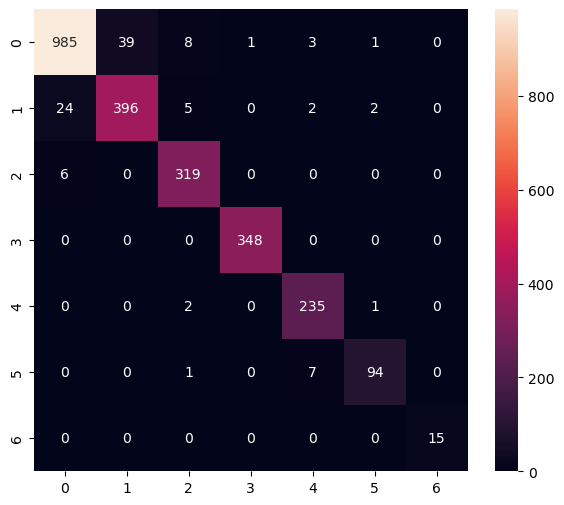

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1037
           1       0.91      0.92      0.92       429
           2       0.95      0.98      0.97       325
           3       1.00      1.00      1.00       348
           4       0.95      0.99      0.97       238
           5       0.96      0.92      0.94       102
           6       1.00      1.00      1.00        15

    accuracy                           0.96      2494
   macro avg       0.96      0.97      0.96      2494
weighted avg       0.96      0.96      0.96      2494



In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [72]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/Users/yoon/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [73]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/m1/nzwkx_t91v1c1lzszjqmggc80000gn/T/tmpfhgh16cs/assets


INFO:tensorflow:Assets written to: /var/folders/m1/nzwkx_t91v1c1lzszjqmggc80000gn/T/tmpfhgh16cs/assets
2025-02-02 19:10:42.575048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-02-02 19:10:42.575065: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-02-02 19:10:42.575291: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/m1/nzwkx_t91v1c1lzszjqmggc80000gn/T/tmpfhgh16cs
2025-02-02 19:10:42.576683: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-02-02 19:10:42.576694: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/m1/nzwkx_t91v1c1lzszjqmggc80000gn/T/tmpfhgh16cs
2025-02-02 19:10:42.580328: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-02-02 19:10:42.626329: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

6728

# Inference test

In [74]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [75]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [76]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [77]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 191 µs, sys: 110 µs, total: 301 µs
Wall time: 260 µs


In [78]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.7367296e-03 1.4460083e-05 9.8577857e-01 7.1971020e-09 7.3028253e-03
 8.3523133e-04 3.3206993e-04]
2
